In [1]:
import theano.sandbox.cuda
theano.sandbox.cuda.use('gpu0') # some other variable would need to be set with the gpuarray backend

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
import scipy.io as sio
from scipy.stats import pearsonr
from scipy import ndimage as nd
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import theano
import theano.tensor as T

import src.numpy_utility as pnu
import src.fwrf as prf
from src.fwrf import FWRF_model, fpX
from src.plots import display_candidate_loss

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [3]:
# folder in which resides the vim-1, dataset, the precalculated feature space and the image dataset.
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/vim-1/"

In [4]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
output_dir = root_dir+"output/"

print "Time Stamp: %s" % timestamp

Time Stamp: Jun-20-2017_1509


# 1a) Load the low-rez images presented.

In [5]:
inputdata_lowrez = sio.loadmat(dataset_dir + "Stimuli.mat")
print inputdata_lowrez.keys()

['seqTrn', '__header__', '__globals__', 'stimVal', 'seqVal', 'stimTrn', '__version__']


In [6]:
npx = 96
npc = 3

trn_size = len(inputdata_lowrez["stimTrn"])
val_size = len(inputdata_lowrez["stimVal"])
data_size = trn_size + val_size

print "trn: %d, val: %d" % (trn_size, val_size)
stim_data = np.ndarray(shape=(data_size, npx, npx, npc), dtype=fpX)

for i,rawim in enumerate(inputdata_lowrez["stimTrn"]):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)               
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    stim_data[i,...] = np.asarray(im)

for i,rawim in enumerate(inputdata_lowrez["stimVal"]):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)         
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    stim_data[trn_size+i,...] = np.asarray(im)
        
stim_data = np.transpose((stim_data - 128) / 128, (0,3,1,2))
print "Data shape = %s" % (stim_data.shape,)

trn_stim_data = stim_data[:trn_size]
val_stim_data = stim_data[trn_size:]

trn: 1750, val: 120
Data shape = (1870, 3, 96, 96)


# 1b) Load the voxel data for all images presented.

In [7]:
voxelset = h5py.File(dataset_dir + "EstimatedResponses.mat")
print voxelset.keys()

[u'dataTrnS1', u'dataTrnS2', u'dataValS1', u'dataValS2', u'roiS1', u'roiS2', u'voxIdxS1', u'voxIdxS2']


In [8]:
subject = 'S1'
roi_names = ['other', 'V1', 'V2', 'V3', 'V3a', 'V3b', 'V4', 'LO']

In [9]:
voxeldata = np.concatenate([voxelset['dataTrn%s'%subject], voxelset['dataVal%s'%subject]], axis=0).astype(dtype=fpX)
voxelroi = voxelset['roi%s'%subject]
voxelidx = voxelset['voxIdx%s'%subject]
print voxeldata.shape

# purge all voxel that have no variance in the validation set

voxelNanMask = ~np.isnan(voxeldata).any(axis=0)
nv = np.sum(voxelNanMask)
print "%d voxels contain valid values for all images" % nv

(1870, 25915)
22701 voxels contain valid values for all images


In [10]:
voxel_data = voxeldata[:, voxelNanMask].astype(dtype=fpX)
voxelROI  = voxelroi[:, voxelNanMask]
voxelIDX  = voxelidx[:, voxelNanMask]
print voxel_data.shape

trn_voxel_data = voxel_data[:trn_size]
val_voxel_data = voxel_data[trn_size:]

(1870, 22701)


## (Optional) Restricted dataset to test the routines quickly.

In [11]:
nv = 300
start_v = (3566 // nv) * nv
trn_voxel_data = trn_voxel_data[:, start_v:start_v+nv]
val_voxel_data = val_voxel_data[:, start_v:start_v+nv]

# 1c) Load precomputed model feature space for all images presented.

In [12]:
model_name = 'deepnet'

trn_feature_dict = h5py.File(dataset_dir + "caffe_refnet_trn_response.h5py", 'r')   # 'r' means that hdf5 file is open in read-only mode
val_feature_dict = h5py.File(dataset_dir + "caffe_refnet_val_response.h5py", 'r')

layerlist = trn_feature_dict.keys()
print layerlist

[u'conv1', u'conv2', u'conv3', u'conv4', u'conv5', u'fc6', u'fc7', u'fc8', u'prob']


In [13]:
# concatenate and sort as list
fmap_max = 1024
order = layerlist[0:8] #+layerlist[7:8]
fmaps = []
fmaps_sizes = []
fmaps_count = 0
for l in order:
    fmap = np.concatenate((np.array(trn_feature_dict[l], dtype=fpX), np.array(val_feature_dict[l], dtype=fpX)), axis=0)        
    if fmap.ndim==2:
        fmap = fmap.reshape(fmap.shape+(1,1))
    if fmap.shape[1]>fmap_max:
        #select the feature map with the most variance to the dataset
        fmap_var = np.var(fmap[:trn_size], axis=(0,2,3))
        most_var = fmap_var.argsort()[-fmap_max:]
        fmap = fmap[:,most_var,:,:]
    print "layer: %s, shape=%s" % (l, (fmap.shape))
    fmaps += [fmap,]
    fmaps_sizes  += [fmap.shape,]
    fmaps_count += fmap.shape[1]
    
trn_feature_dict.close()
val_feature_dict.close()

layer: conv1, shape=(1870, 96, 55, 55)
layer: conv2, shape=(1870, 256, 27, 27)
layer: conv3, shape=(1870, 384, 13, 13)
layer: conv4, shape=(1870, 384, 13, 13)
layer: conv5, shape=(1870, 256, 13, 13)
layer: fc6, shape=(1870, 1024, 1, 1)
layer: fc7, shape=(1870, 1024, 1, 1)
layer: fc8, shape=(1870, 1000, 1, 1)


## Display an example of image and feature space.

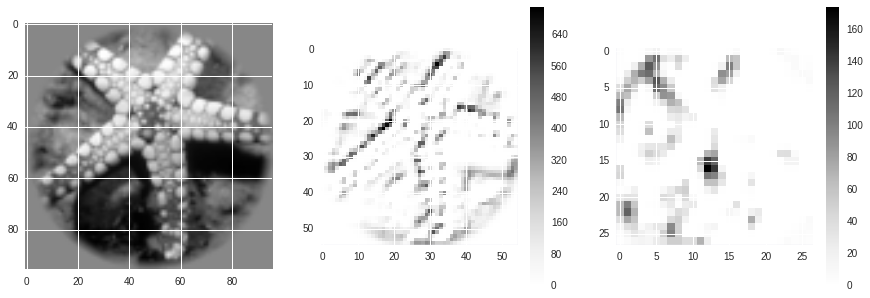

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(trn_stim_data[5,0,:,:], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(fmaps[0][5,2,:,:], interpolation='None')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(fmaps[1][5,10,:,:], interpolation='None')
plt.colorbar()

In [15]:
# aliases
nf = fmaps_count
fmaps_res_count = len(fmaps)

# make sure we are using float32
print fmaps[0].dtype

float32


# 2) MODELS
### There are 4 steps to the fwRF model
1) Define the model object fwrf (class FWRF_model), where the input and batch sizes are initialized. This formulation is open ended: we need to provide feature maps of some sort but the input can be the feature maps themselves or any low level information and a theano expression that would generate these feature maps.

2) Compute the model-space tensor (MST) by calling fwrf.precompute_mst_data(...) where one can choose a nonlinearity and normalize the final tensor.

3) Run the model on the data by calling fwrf.shared_model_training(...). "Shared model" is the method, meaning that all voxels pick a model from the same grid.

4) Run the resulting voxel models on the validation set to get an accuracy score. This can be done either with the MST of the validation with fwrf.validate_models(...) or by creating a new theano expression for the output of the fwRF model with the parameters learned in (3). To do this, use fwrf_symbolic_prediction(...). This returns a theano expression.

## Define the inputs
We can either connect the feature maps of the network directly or some precomputed values provided in a suitable list

In [16]:
#feature maps symbolic variables:
_fmaps = []
for r in range(fmaps_res_count):
    _fmaps += [T.tensor4(),] # note this has to be done explicitely, we can't just replicate the tensor object
_invar = _fmaps
# vs. connecting another theano network directly:
#_fmaps = [L.get_output(fm, deterministic=True) for fm in _aux]
#_invar = [X,]

## Define the search parameters

In [17]:
lx = ly = 20.
nx = ny = 10
smin, smax = 0.7, 8.
ns = 8

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
sharedModel_specs = [[(0., lx), (0., ly), (smin, smax)], [prf.linspace(nx), prf.linspace(ny), prf.logspace(ns)]]
# initial values of the fwrf model parameters
voxelParams = [np.full(shape=(nv, nf), fill_value=0.0, dtype=fpX), np.full(shape=(nv), fill_value=0.0, dtype=fpX)]

rx = sharedModel_specs[1][0](*sharedModel_specs[0][0])
ry = sharedModel_specs[1][1](*sharedModel_specs[0][1])
rs = sharedModel_specs[1][2](*sharedModel_specs[0][2])
print "G = %d\n" % (nx*ny*ns)
#print range:
print "range x"
print rx
print "range y"
print ry
print "range s"
print rs

G = 800

range x
[-9. -7. -5. -3. -1.  1.  3.  5.  7.  9.]
range y
[-9. -7. -5. -3. -1.  1.  3.  5.  7.  9.]
range s
[ 0.69999999  0.99137908  1.40404642  1.98848879  2.81620884  3.98847222
  5.6486969   8.        ]


## Select the indice of one of the receptive field size to visualize the rf weight masks at every resolution required by the feature space.

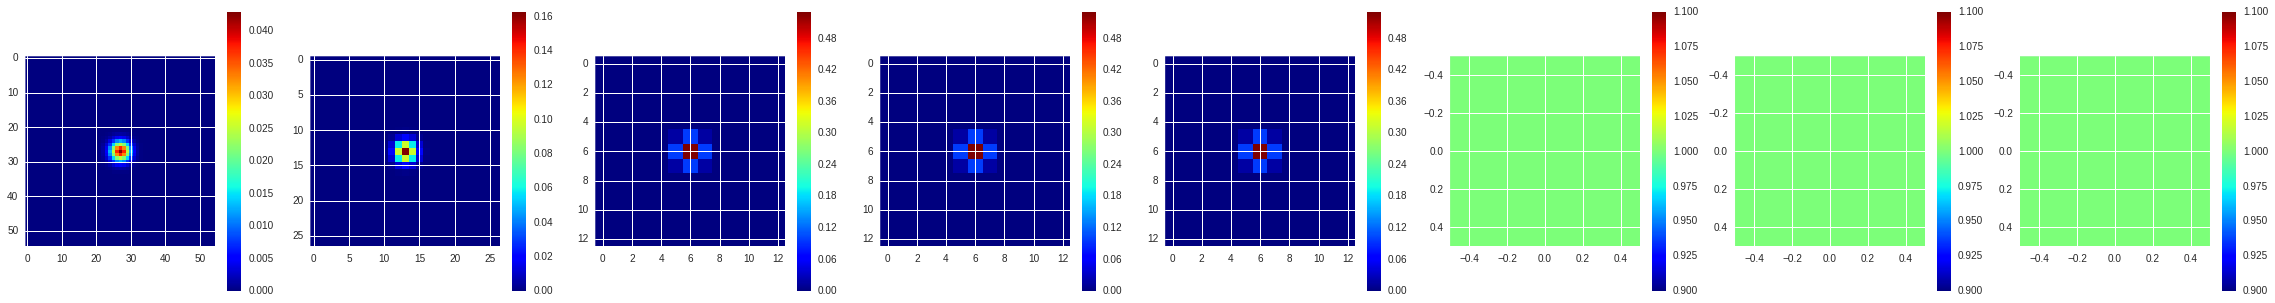

In [22]:
ith_rf_size = 0

n = len(fmaps_sizes)
plt.figure(figsize=(5*n,5))
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
for i,r in enumerate(fmaps_sizes):
    _,_,z = pnu.make_gaussian_mass(0., 0., sigmas[ith_rf_size], r[2], size=20.)
    plt.subplot(1,n,i+1)
    plt.imshow(z, interpolation='None', cmap='jet')
    plt.colorbar()

## Define the model
The model allocates the necessary buffers and pre-compile the theano expressions. 

In [33]:
reload(prf)
from src.fwrf import FWRF_model, fpX

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [34]:
fwrf = FWRF_model(_fmaps, fmaps_sizes, _invar, fmaps_sizes,
    batches_p=(200, ny*nx), batches_o=(200, 300, ny*nx), batches_t=(200, 10*ny*nx),\
    view_angle=lx, verbose=True)

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 100, 55, 55)
> feature map candidates 1 with shape (1, 100, 27, 27)
> feature map candidates 2 with shape (1, 100, 13, 13)
> feature map candidates 3 with shape (1, 100, 13, 13)
> feature map candidates 4 with shape (1, 100, 13, 13)
> feature map candidates 5 with shape (1, 100, 1, 1)
> feature map candidates 6 with shape (1, 100, 1, 1)
> feature map candidates 7 with shape (1, 100, 1, 1)
  total number of feature maps = 4424, in 8 layers
  feature map candidate using approx 1.6 Mb of memory (VRAM and RAM)


Layer	: <lasagne.layers.input.InputLayer object at 0x7fc805694f90>
Name	: None
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 4424, 100)


Layer	: <src.fwrf.svFWRFLayer object at 0x7fc805685090>
Name	: None
Type	: <class 'src.fwrf.svFWRFLayer'>
Shape	: (None, 300, 100)
Params
        |-- W         : (4424, 300, 100)
        |-- b         : (1, 300, 100)



COMPILING...
4.02 seconds to compile theano functi

## Precompute and save the modelspace tensor

In [20]:
log_act_func = lambda x: np.log(1+np.sqrt(np.abs(x)))
log_act_func_2 = lambda x: np.log(np.power(1+np.square(x), 0.25))

mst_data = fwrf.precompute_mst_data(fmaps, sharedModel_specs, verbose=True, dry_run=False, nonlinearity=log_act_func_2, \
                                        zscore=True, trn_size=trn_size, epsilon=1e-3)
print mst_data.shape


>> Storing the full modelspace tensor will require approx 24.655Gb of RAM!
>> Will be divided in chunks of 3.082Gb of VRAM!

Precomputing mst candidate responses...


100%|██████████| 8/8 [00:21<00:00,  2.59s/it]

800 mst candidate responses took 21.296s @ 37.566 models/s
Applying nonlinearity to modelspace tensor...



8it [06:06, 45.86s/it]

Z-scoring modelspace tensor...



8it [01:53, 14.19s/it]

(1870, 4424, 1, 800)


In [21]:
print np.amin(mst_data), np.amax(mst_data)

-33.191 352.83


In [23]:
# split the model space tensor into trn and val set.
trn_mst_data = mst_data[:trn_size]
val_mst_data = mst_data[trn_size:]

## Run the models

In [35]:
val_scores, best_scores, best_epochs, best_rf_params, best_candidates, best_w_params, best_avg, best_std = fwrf.shared_model_training(\
    trn_mst_data, trn_voxel_data, sharedModel_specs, voxelParams,\
    val_test_size=350, lr=1e-4, l2=0., num_epochs=40, output_val_scores=-1, verbose=True, dry_run=False)


Voxel-Candidates model optimization...
Grad. Desc. performed in 7 batch with batch size 200 and residual 0
1 voxel batches of size 300 with residual 0
8 candidate batches of size 100 with residual 0
for 240000 voxelmodel fits.


0it [00:00, ?it/s]


  Voxel 0:300 of 300, Candidate 0:100 of 800
    validation <loss>: 0.005654
    validation <loss>: 0.005634
    validation <loss>: 0.005623
    validation <loss>: 0.005616
    validation <loss>: 0.005612
    validation <loss>: 0.005611
    validation <loss>: 0.005610
    validation <loss>: 0.005611
    validation <loss>: 0.005612
    validation <loss>: 0.005613
    validation <loss>: 0.005615
    validation <loss>: 0.005617
    validation <loss>: 0.005620
    validation <loss>: 0.005622
    validation <loss>: 0.005625
    validation <loss>: 0.005628
    validation <loss>: 0.005631
    validation <loss>: 0.005634
    validation <loss>: 0.005637
    validation <loss>: 0.005640
    validation <loss>: 0.005643
    validation <loss>: 0.005646
    validation <loss>: 0.005649
    validation <loss>: 0.005652
    validation <loss>: 0.005655
    validation <loss>: 0.005659
    validation <loss>: 0.005662
    validation <loss>: 0.005665
    validation <loss>: 0.005668
    validation <loss>: 0.0

1it [10:47, 647.40s/it]


---------------------------------------------------------------------
40 Epoch for 240000 voxelmodels took 647.409s @ 370.708 voxelmodels/s


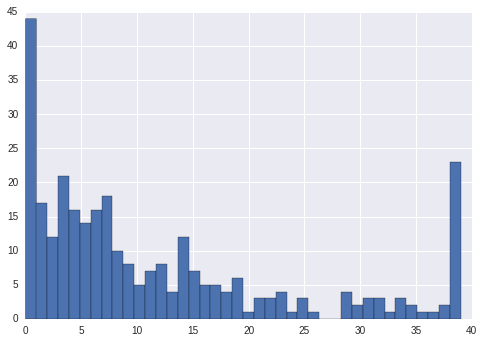

In [36]:
_=plt.hist(best_epochs, bins=40)

## Show a coarse distribution of position and sizes of the selected RFs

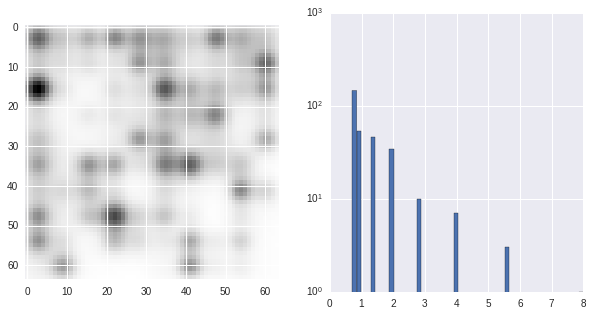

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
_,_,g_stack = pnu.make_gaussian_stack(best_rf_params[:,0], best_rf_params[:,1], best_rf_params[:,2], 64, size=20., dtype=fpX)
plt.imshow(np.sum(g_stack, axis=0), interpolation='None')
plt.subplot(1,2,2)
_=plt.hist(best_rf_params[:,2], bins=50)
plt.yscale('log')

## If output_val_scores was set to True, display the validation score for all candidate of one voxels and the time series of the best candidates for all voxels.

[ 3.          9.          0.99137908]
score range = (0.003767, 0.005170)


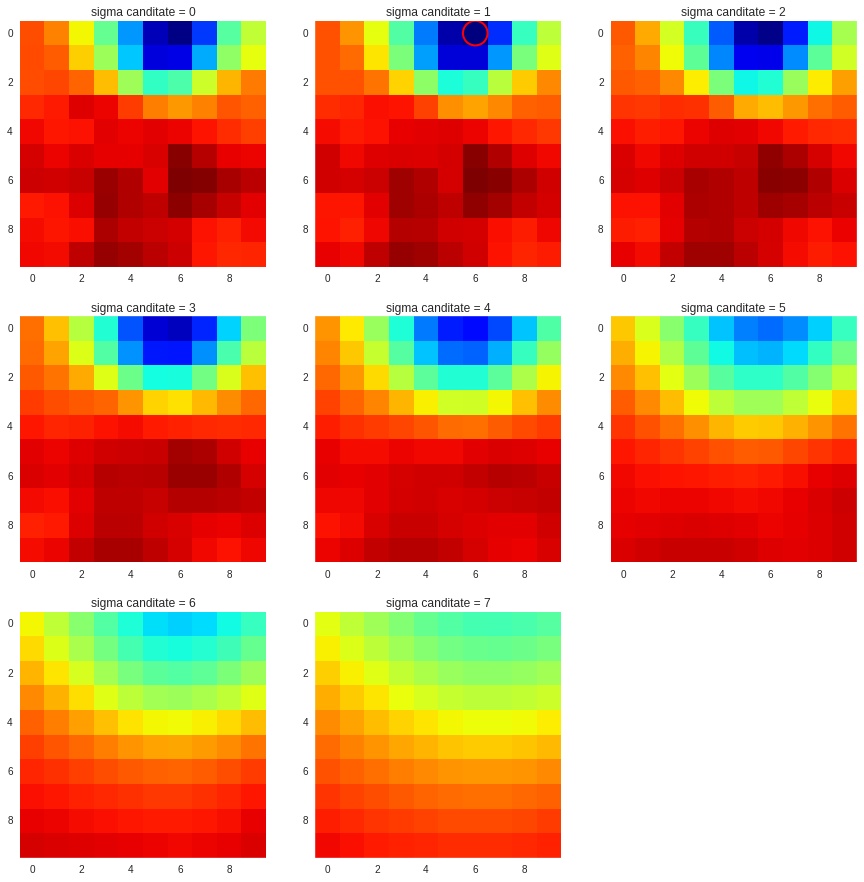

In [38]:
vidx = 266
print best_rf_params[vidx,:]
fig1 = display_candidate_loss(val_scores[-1,vidx,:], nx, ny, ns)

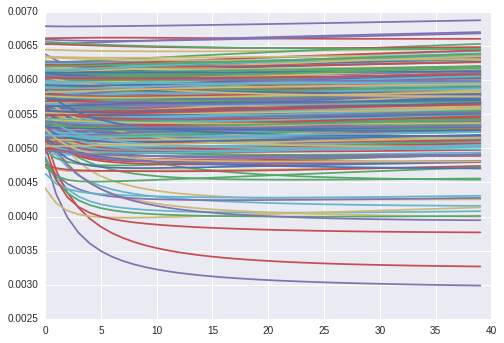

In [39]:
for v in range(val_scores.shape[1]):
    plt.plot(val_scores[:,v,best_candidates[v]])

## Validate the best models and display the distribution of prediction accuracy.

In [29]:
val_pred, val_cc = fwrf.validate_models(val_mst_data, val_voxel_data, best_candidates, best_w_params)

0 voxel batches of size 1000 with residual 300


1it [00:05,  5.84s/it]


max cc = 0.841830
sum(cc>0.2) = 78


(-0.4, 0.9)

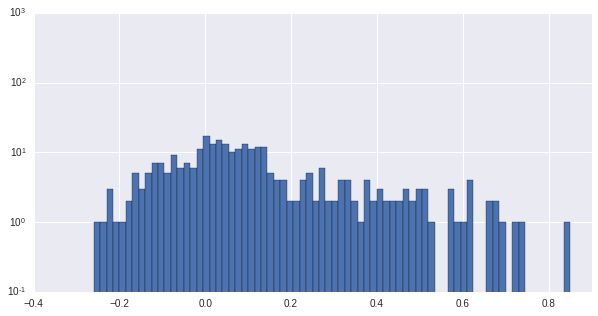

In [30]:
print "max cc = %f" % np.max(val_cc)
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, val_cc))
plt.figure(figsize=(10,5))
_=plt.hist(val_cc[:], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

[[ 1.          0.84183046]
 [ 0.84183046  1.        ]]


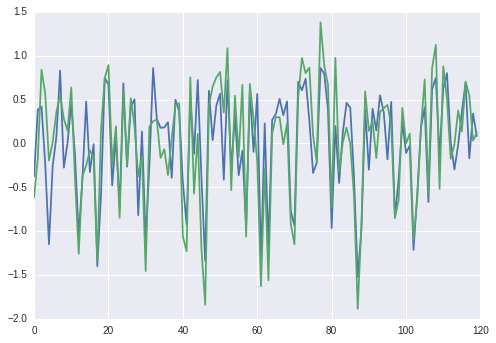

In [31]:
plt.plot(val_pred[:,vidx])
plt.plot(val_voxel_data[:,vidx])

print np.corrcoef(val_pred[:,vidx], val_voxel_data[:,vidx])

## Save the results

In [ ]:
ex_file_name = "fwrf_%s_%s_%s_data.pkl" % (model_name, subject, timestamp)
ex_file = open(output_dir + ex_file_name, 'wb')
ex_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'grid': [sharedModel_specs[1][0](*sharedModel_specs[0][0]), 
                      sharedModel_specs[1][1](*sharedModel_specs[0][1]),
                      sharedModel_specs[1][2](*sharedModel_specs[0][2])],
             'fmaps_res_count': fmaps_res_count,
             'fmaps_count': fmaps_count,
             'fmaps_sizes': fmaps_sizes,      
             'scores': best_scores,
             'rf_params': best_rf_params,
             'w_params': best_w_params,
             'normavg': best_avg,
             'normstd': best_std, 
             'val_pred': val_pred,
             'val_cc': val_cc}
pickle.dump(ex_values, ex_file)
ex_file.close()
print ex_file_name

# Split accuracy by layer and roi

In [ ]:
#find the start and end point of the feature map partitions
fmaps_count = len(fmaps_sizes)
partitions = [0,]
for r in fmaps_sizes:
    partitions += [partitions[-1]+r[1],]
print partitions

In [ ]:
partition_val_pred = np.ndarray(shape=(fmaps_count,)+val_pred.shape, dtype=fpX)
partition_val_cc   = np.ndarray(shape=(fmaps_count,)+val_cc.shape, dtype=fpX)

for l in range(fmaps_count):
    partition_params = [np.zeros(p.shape, dtype=fpX) for p in best_w_params]  
    partition_params[0][:, partitions[l]:partitions[l+1]] = best_w_params[0][:, partitions[l]:partitions[l+1]]
    partition_params[1][:] = best_w_params[1][:]

    partition_val_pred[l,...], partition_val_cc[l,...] = fwrf.validate_models(val_mst_data, val_voxel_data, best_candidates, partition_params)

In [ ]:
# calculate covariances
partition_r = np.ndarray(shape=(fmaps_count, nv))
for v in range(nv):
    full_c = np.cov(val_pred[:,v], val_voxel_data[:,v])
    for l in range(fmaps_count):
        part_c = np.cov(partition_val_pred[l,:,v], val_voxel_data[:,v])
        partition_r[l,v] = part_c[0,1]/np.sqrt(full_c[0,0]*full_c[1,1])

In [ ]:
part_file = open(output_dir + "fwrf_%s_%s_%s_part.pkl" % (model_name, subject, timestamp), 'wb')
part_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'val_pred': partition_val_pred,
             'val_cc': partition_val_cc,
             'val_ri': partition_r}
pickle.dump(part_values, part_file)
part_file.close()

In [ ]:
nROI = int(np.max(voxelROI))+1
nL   = fmaps_count

partition_R_avg = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
for roi in range(nROI):
    roi_mask = np.logical_and(voxelROI.flatten()==roi, val_cc>0.27)    
    for l in range(fmaps_count):
        partition_R_avg[l,roi] = np.mean(partition_r[l, roi_mask] /  val_cc[roi_mask])
        partition_R_std[l,roi] = np.std(partition_r[l, roi_mask])
#plt.imshow(partition_R_avg, interpolation='None')

In [ ]:
from matplotlib.pyplot import cm 
color=iter(cm.magma(np.linspace(0,1,nL)))

plt.figure(figsize=(20,10))
c=next(color)
plist = []
_ = plt.bar(np.arange(len(roi_names)), partition_R_avg[0,:], yerr=partition_R_std[0,:], color=c, align='center')
plist += [_,]
for l in range(1,nL):
    c=next(color)
    _= plt.bar(np.arange(len(roi_names)), partition_R_avg[l,:], bottom=np.sum(partition_R_avg[:l,:],axis=0), yerr=partition_R_std[l,:], color=c,\
        align='center', tick_label=roi_names)
    plist += [_,]
plt.legend(plist, ['layer %d' % l for l in range(1,len(plist)+1)])
plt.ylim([0,1])
plt.ylabel('Layer contribution to total prediction accuracy\n (averaged over voxels in roi)')